In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 182040794/182040794 [07:28<00:00, 405652.33it/s] 


In [4]:
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 64275384/64275384 [03:05<00:00, 347315.18it/s] 


In [5]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)

/home/maverick/miniconda3/envs/Dl_ops/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maverick/miniconda3/envs/Dl_ops/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/maverick/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.4MB/s]


In [6]:
resnet50 = models.resnet50(pretrained=True)
ct = 0
for child in resnet50.children():
  ct += 1
  if ct < 7:
    for param in child.parameters():
        param.requires_grad = False

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()))

In [10]:
train_loss_history = []
train_accuracy_history = []
for epoch in range(1):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}', unit='batch', leave=False):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = resnet50(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

  print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%")




Epoch 1, Train Loss: 0.5859, Train Accuracy: 82.24%


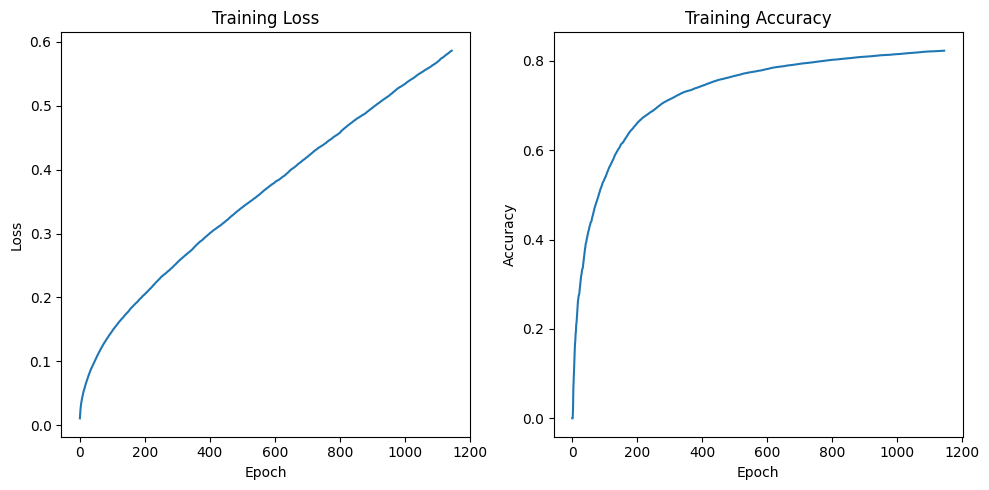

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 87.88%
